*Теоретический материал:* https://youtu.be/3LeYSKkVCMk?t=253

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=2013

In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
import time

#Загружаем базу


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Кластеризация базы hh

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=2146

In [ ]:
fixed_df = pd.read_csv('/content/drive/My Drive/Базы/база hh кластеризация по резюме.csv')  # Читаем данные из загруженной базы

## Содержимое базы


In [ ]:
fixed_df # Отображаем содержимое базы

,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последеняя/нынешняя должность,Образование и ВУЗ,Авто
0,"Женщина, 21 год, родилась 26 марта 1998",30 000 руб.,Специалист по поддержке пользователей,"Тимашевск, готова к переезду, готова к команди...","проектная работа, стажировка, частичная занят...","удаленная работа, гибкий график, полный день,...",Опыт работы 4 месяца\n\nОктябрь 2018 — январь ...,Медицинская сестра палатная,"Среднее специальное образование 2018 ГБПОУ ""Ей...",NaN
1,"Мужчина, 23 года, родился 17 января 1996",NaN,Программист,"Воронеж, не готов к переезду, не готов к коман...",полная занятость,полный день,Опыт работы 2 года 9 месяцев\n\nОктябрь 2016 —...,Сервисный инженер,Образование Среднее специальное образование,Имеется собственный автомобиль
2,Мужчина,NaN,Веб-программист,"Мытищи, не готов к переезду, не готов к команд...",полная занятость,полный день,Опыт работы 3 года 1 месяц\n\nЯнварь 2019 — ию...,Web-разработчик,Неоконченное высшее образование 2019 Московски...,NaN
3,"Мужчина, 35 лет, родился 24 октября 1983",50 000 руб.,Аналитик-консультант 1С,"Нижний Новгород, не готов к переезду, готов к ...",полная занятость,"гибкий график, полный день, сменный график",Опыт работы 13 лет 1 месяц\n\nМарт 2016 — по н...,Специалист по планированию производства,Высшее образование 2006 Волго-Вятская академия...,NaN
4,"Мужчина, 28 лет, родился 3 ноября 1990",45 000 руб.,Электромонтер связи,"Москва, м. Отрадное, готов к переезду, готов к...",полная занятость,полный день,Опыт работы 7 лет 8 месяцев\n\nДекабрь 2018 — ...,Инженер,Среднее специальное образование 2011 Колледж с...,NaN
...,...,...,...,...,...,...,...,...,...,...
7773,"Мужчина , 42 года , родился 4 апреля 1977",120 000 руб.,Администратор сайта,"Москва , м. Выхино , не готов к переезду , не...","частичная занятость, проектная работа, полная...","гибкий график, полный день, сменный график, в...",Опыт работы 11 лет 10 месяцев\n\nМарт 2014 — п...,Менеджер по веб-проектам,Высшее образование 2000 Академия Федеральной с...,NaN
7774,"Мужчина , 22 года , родился 30 января 1997",30 000 руб.,Системный администратор,"Санкт-Петербург , м. Гражданский проспект , н...",полная занятость,"сменный график, вахтовый метод, удаленная работа",Опыт работы 9 месяцев\n\nДекабрь 2017 — Июнь ...,Системный администратор,Среднее специальное образование 2018 Колледж м...,NaN
7775,"Мужчина , 31 год , родился 4 марта 1988",35 000 руб.,Программист,"Новочеркасск , не готов к переезду , готов к р...",полная занятость,полный день,Опыт работы 4 года 2 месяца\n\nДекабрь 2012 — ...,Продавец-консультант,Среднее специальное образование 2008 НМК Прогр...,NaN
7776,"Мужчина , 22 года , родился 21 июня 1997",NaN,Младший программист,"Санкт-Петербург , не готов к переезду , не гот...",полная занятость,полный день,Опыт работы 4 месяца\n\nМай 2016 — Август 201...,Младший инженер-программист,Неоконченное высшее образование 2021 Санкт-Пет...,NaN


In [ ]:
# Выводим полную информацию по одной записи из базы
n = 4                                    # Номер записи в базе
for i in range(len(fixed_df.values[n])): # Пробегаем по всем столбцам данных выбранной записи
  print(i, " ", fixed_df.values[n][i])   # Печатаем содержимое очередной ячейки с данными

0   Мужчина, 28 лет, родился 3 ноября 1990
1   45 000 руб.
2   Электромонтер связи
3   Москва, м. Отрадное, готов к переезду, готов к командировкам
4   полная занятость
5   полный день
6   Опыт работы 7 лет 8 месяцев

Декабрь 2018 — июнь 2019 7 месяцев ОАО КОМКОР Москва Информационные технологии, системная интеграция, интернет... Инженер Устранение аварий на линиях связи. Замена и настройка серверного и клиентского оборудования.

Июнь 2011 — июнь 2018 7 лет 1 месяц ПАО МГТС Технический специалист Монтаж и обслуживание СКС (Телефония, интернет, телевидение и видеонаблюдение) Замена и настройка неисправного абонентского оборудования. Обслуживание волоконно-оптических линий связи. Сварка ВОЛС. Сварочный аппарат Fujikura S-12. Работа с измерительными приборами.
    

7   Инженер
8   Среднее специальное образование 2011 Колледж связи №54 Сети связи и системы коммутации, Техник
9   nan


## Парсим базу


In [ ]:
'''
  Функция получения данных о поле
    Входные данные:
      - arg - строка данных (для данной функции передаем первую колонку из таблицы)    
    Функция возвращает:
      - 0 (для женского пола) или 1 (для мужского пола)
'''
def getParameterSex(arg):
  out = 0            # По умолчанию женский пол
  if(arg[0] == "М"): # Если в arg[0] буква М, то в выход записываем 1
    out = 1
  return out         # Возвращаем числовое представление пола

'''
  Функция получения ланных о возрасте
    Входные данные:
      - arg - строка данных (для данной функции передаем первую колонку из таблицы)
    Функция возвращает:
      - возраст (int)
'''
def getParameterAge(arg):
  out = 0                                             # По умолчанию в выход записываем 0
  if (len(arg) > 7):                                  # Если в строке больше 7 символов (значит имеется информация о возрасте)
    index = 0                                         # В index записываем позицию в строке, с которой начинается возраст
    while ((arg[index] != " ") & (index < len(arg))): # Ищем первый пробел во входной строке (далее следует возраст)
      index += 1                                      # Увеличиваем индекс    
    if (index != len(arg)-1):                         # Если index меньше длинны строки
      out = int(arg[index+1:index+3])                 # В out записываем возраст (2 символа после найденного пробела во входной строке)
  return out                                          # Возвращаем возраст

'''
  Функция  получения данных о возрасте по году рождения
    Входные данные:
      - arg - строка данных (для данной функции передаем первую колонку из таблицы)
    Функция возвращает:
      - возраст (int)
'''
def getParameterAge2(arg):
  out = 0                                             # По умолчанию в выход записываем 0
  if (len(arg) > 7):                                  # Если в строке больше 7 символов (значит имеется информация о возрасте)
    ageStr = arg[len(arg)-4:len(arg)]                 # Получаем последние 4 символа во входной строке (год рождения)
    out = 2020 - int(ageStr)                          # Получаем возраст   
  return out                                          # Возвращаем возраст

'''
  Функция получения OHE-представления данных о возрасте
    Входные данные:
      - arg - строка данных (для данной функции передаем первую колонку из таблицы)
    Функция возвращает:
      - OHE представление возраста по 11 классам (list)
'''
def getParameterAgeVect(arg):
  out = getParameterAge2(arg) # Получаем возраст по году рождения 
  outClass = 0                # По умолчанию в out записываем 0

  if (out > 18): # Если старше 19 лет, изменяем out на 1
    outClass = 1
  if (out > 23): # Если старше 23 лет, изменяем out на 2
    outClass = 2
  if (out > 28): # Если старше 28 лет, изменяем out на 3
    outClass = 3
  if (out > 33): # Если старше 33 лет, изменяем out на 4
    outClass = 4
  if (out > 38): # Если старше 38 лет, изменяем out на 5
    outClass = 5
  if (out > 43): # Если старше 43 лет, изменяем out на 6
    outClass = 6
  if (out > 48): # Если старше 48 лет, изменяем out на 7
    outClass = 7
  if (out > 53): # Если старше 53 лет, изменяем out на 8
    outClass = 8 
  if (out > 58): # Если старше 58 лет, изменяем out на 9
    outClass = 9 
  if (out > 63): # Если старше 63 лет, изменяем out на 10
    outClass = 10  
  return list(utils.to_categorical(outClass, 11).astype('int')) # Возвращаем OHE представление возраста по 11 классам

'''
  Функция получения данных о желаемой зарплате
    Входные данные:
      - arg - строка данных (для данной функции передаем вторую колонку из таблицы)
    Функция возвращает:
      - желаемая зарплата (int)
'''
def getParameterSalary(arg):
  out = -1                     # По умолчанию в out записываем -1 (если зарплата не указана)
  if (type(arg) != float):     # Проверяем, чтобы в arg не было float-данных
    index = 0                  # В index запишем позицию последнего пробела во входной строке
    for i in range(len(arg)):  # Пробегаем по всей строке
      if (arg[i]==" "):        # Если очередной символ это пробел
        index = i              # Записываем позицию пробела в index
    salaryStr = ""             # Строкове представление зарплаты
    for i in range(index):     # Пробегаем в цикле от 0 до index (с начала строки до последнего пробела)
      if (i != index-4):       # Если это не пробельный символ в зарплате (в базе зарплата храниться в формате 45 000)
        salaryStr += arg[i]    # Записываем очередной символ в salaryStr
    out = int(salaryStr)       # Преобразуем в int
  return out                   # Возвращаем зарплату

'''
  Функция получения данных о городе проживания
    Входные данные:
      - arg - строка данных (для данной функции передаем четвертую колонку из таблицы)
    Функция возвращает:
      - OHE-представление города проживания по 4 классам
'''
def getParameterSity(arg):
  out = [0, 0, 0, 1]         # По умолчанию город проживания не Москва, не Санкт-Петербург и не миллионник  
  index = 0                  # В индекс запишем позицию символа первой запятой во входной строке
  while (arg[index] != ","): # Пробегаем по всем символам входной строки, пока не встретим запятую
    index += 1               # Увеличиваем index на 1  
  sityStr = arg[:index]      # Записываем в sityStr город прживания    
  millionSities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград" # Строка, содержащая города милионники  
  if (sityStr == "Москва"):  # Если город проживания - Москва
    out[0] = 1               # Записываем в 0-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию
  if (sityStr == "Санкт-Петербург"): # Если город проживания - Санкт-Петербург
    out[1] = 1               # Записываем в 1-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию
  if (sityStr in millionSities): # Если город проживания один из городов милионников
    out[2] = 1               # Записываем во 2-позицию 1
    out[3] = 0               # Обнуляем значение out по умолчанию  
  return out                 # Возвращаем OHE-представление города проживания по 4 классам

'''
  Функция получения данных о желаемых типах занятости
    Входные данные:
      - arg - строка данных (для данной функции передаем пятую колонку из таблицы)
    Функция возвращает:
      - список желаемых типов занятости
'''
def getParameterEmployment(arg):
  out = [0, 0, 0, 0]                 # По умолчанию желаемый тип занятости не указан  
  if ("стажировка" in arg):          # Если во входной строке имеется пункт: стажировка
    out[0] = 1                       # Записываем в 0-позицию 1
  if ("частичная занятость" in arg): # Если во входной строке имеется пункт: частичная занятость
    out[1] = 1                       # Записываем в 1-позицию 1
  if ("проектная работа" in arg):    # Если во входной строке имеется пункт: проектная работа
    out[2] = 1                       # Записываем в 2-позицию 1
  if ("полная занятость" in arg):    # Если во входной строке имеется пункт: полная занятость
    out[3] = 1                       # Записываем в 3-позицию 1
  return out                         # Возвращаем список желаемых типов занятости

'''
  Функция получения данных о желаемых графиках работы
    Входные данные:
      - arg - строка данных (для данной функции передаем шестую колонку из таблицы)
    Функция возвращает:
      - список желаемых графиков работы
'''
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]              # По умолчанию желаемый график не указан  
  if ("гибкий график" in arg):    # Если во входной строке имеется пункт: гибкий график
    out[0] = 1                    # Записываем в 0-позицию 1
  if ("полный день" in arg):      # Если во входной строке имеется пункт: полный день
    out[1] = 1                    # Записываем в 1-позицию 1
  if ("сменный график" in arg):   # Если во входной строке имеется пункт: сменный график
    out[2] = 1                    # Записываем в 2-позицию 1
  if ("удаленная работа" in arg): # Если во входной строке имеется пункт: удаленная работа
    out[3] = 1                    # Записываем в 3-позицию 1  
  return out                      # Возвращаем список желаемых графиков работы

'''
  Функция получения данных об образовании
    Входные данные:
      - arg - строка данных (для данной функции передаем девятую колонку из таблицы)
    Функция возвращает:
      - список с данными об образовании
'''
def getParameterEducation(arg):
  out = [0, 0, 0, 0]                 # По умолчанию образование не указано  
  if ("Высшее" in arg):              # Если во входной строке имеется пункт: Высшее
    out[0] = 1                       # Записываем в 0-позицию 1
  if ("Higher education" in arg):    # Если во входной строке имеется пункт: Higher education
    out[0] = 1                       # Записываем в 0-позицию 1
  if ("Среднее специальное" in arg): # Если во входной строке имеется пункт: Среднее специальное
    out[1] = 1                       # Записываем в 1-позицию 1
  if ("Неоконченное высшее" in arg): # Если во входной строке имеется пункт: Неоконченное высшее
    out[2] = 1                       # Записываем в 2-позицию 1
  if ("Среднее образование" in arg): # Если во входной строке имеется пункт: Среднее образование
    out[3] = 1                       # Записываем в 3-позицию 1  
  return out                         # Возвращаем список с данными об образовании

'''
  Функция получения данных об опыте работы
    Входные данные:
      - arg - строка данных (для данной функции передаем седьмую колонку из таблицы)
    Функция возвращает:
      - стаж работы в месяцах (int)
'''
def getParameterExperience(arg):
  numberStr = ['1','2','3','4','5','6','7','8','9','0'] # Массив цифр в строковом представлении
  out = 0                                               # По умолчанию без опыта работы  
  symbols = 0                                           # В symbols будет храниться количество не пробельных символов

  for s in arg:                                         # Пробегаем по всей входной строке
    if (s != " "):                                      # Если очередной симвло не пробел
      symbols += 1                                      # Увеличиваем symbols на 1   

  if (symbols > 10):                                    # Если имеются еще какие-то данные, помимо строки: опыт работы
    spacesIndexes = []                                  # Список, в который запишем первые 5 пробелов во входной строке
    index = 0                                           # Счетчик символов 
    while ((len(spacesIndexes) < 5) & (index < len(arg))): # Пробегаем по циклу, пока не найдем 5 пробелов или пока не достигнем конца входной строки
      if (arg[index] == " "):                           # Если очередной символ пробел
        spacesIndexes.append(index)                     # Запимшем индекс пробела в spacesIndexes
      index += 1                                        # Увеличиваем счетчик    
    years = 0                                           # Количество отработанных лет
    months = 0                                          # Количество отработынных месяцов
    if (arg[spacesIndexes[2]+1] != "м" and arg[spacesIndexes[2]+1] != "m"): # Если отработал больше 1 года (есть данные о годах)
      if (len(spacesIndexes) >= 3):                     # Если найдено больше 2 пробелов (значит есть данные о годах)
        yearsStr = arg[spacesIndexes[1]+1:spacesIndexes[2]] # Получаем символы между вторым и третьим пробелом из spacesIndexes
        yaerIsNumber = True                             # Флаг того, что количество лет представлено числом
        for s in yearsStr:                              # Пробегаем по всем символам года
          yaerIsNumber = yaerIsNumber and (s in numberStr) # Перезаписываем yaerIsNumber в зависимости от s in numberStr 
        if yaerIsNumber:                                # Если количество лет представлено числом
          years = int(yearsStr)                         # Получаем числовое представление
      if (len(spacesIndexes) >= 5):                     # Если найдено больше 4 пробелов (значит могут быть данные о месцах)
        monthsStr = arg[spacesIndexes[3]+1:spacesIndexes[4]] # Получаем символы между двумя последними пробелами из spacesIndexes
        monthIsNumber = True                            # Флаг того, что количество месяцев представлено числом
        for s in monthsStr:                             # Пробегаем по всем символам мнсяцев
          monthIsNumber = monthIsNumber and (s in numberStr) # Перезаписываем yaerIsNumber в зависимости от s in numberStr 
        if monthIsNumber:
          months = int(monthsStr)                       # Получаем числовое представление
    else:                                               # Если отработал меньше одного года
      if (len(spacesIndexes) >= 3):                     # Если найдено больше 2 пробелов (значит есть данные о месяцах)
        monthsStr = arg[spacesIndexes[1]+1:spacesIndexes[2]] # Получаем символы между вторым и третьим пробелом из spacesIndexes
        months = int(monthsStr)                         # Получаем числовое представление
        
    out = 12*years + months                             # Считаем общий стаж в месяцах  
  return out                                            # Возвращаем стаж работы в месяцах

'''
  Функция получения OHE-представления данных об опыте работы
    Входные данные:
      - arg - строка данных (для данной функции передаем седьмую колонку из таблицы)
    Функция возвращает:
      - OHE представление опыта работы по 11 классам (list)
'''
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg) # Получаем данные об опыте работы
  outClass = 0    # По умолчанию в out записываем 0
  if (out > 6):   # Если опыт работы составляет более 6 месяцев, изменяем out на 1
    outClass = 1
  if (out > 12):  # Если опыт работы составляет более 12 месяцев, изменяем out на 2
    outClass = 2 
  if (out > 24):  # Если опыт работы составляет более 24 месяцев, изменяем out на 3
    outClass = 3
  if (out > 36):  # Если опыт работы составляет более 36 месяцев, изменяем out на 4
    outClass = 4
  if (out > 60):  # Если опыт работы составляет более 60 месяцев, изменяем out на 5
    outClass = 5
  if (out > 96):  # Если опыт работы составляет более 96 месяцев, изменяем out на 6
    outClass = 6
  if (out > 120): # Если опыт работы составляет более 120 месяцев, изменяем out на 7
    outClass = 7
  if (out > 156): # Если опыт работы составляет более 156 месяцев, изменяем out на 8
    outClass = 8
  if (out > 192): # Если опыт работы составляет более 192 месяцев, изменяем out на 9
    outClass = 9 
  if (out > 240): # Если опыт работы составляет более 240 месяцев, изменяем out на 10
    outClass = 10  
  return list(utils.to_categorical(outClass, 11).astype('int')) # Возвращаем OHE-представление данных об опыте работы по 11 классам

'''
  Функция получения полного набора данных по одной записе из базы
    Входные данные:
      - val - запись из базы
    Функция возвращает:
      - массив числовых данных, соответствующий исходной записи
'''
def getAllParameters(val):
  sex = getParameterSex(val[0])               # Получаем пол
  age = getParameterAge2(val[0])              # Получаем возраст
  salary = getParameterSalary(val[1])         # Получаем желаемый уровень зарплаты
  sity = getParameterSity(val[3])             # Получаем город проживания
  employment = getParameterEmployment(val[4]) # Получаем информацию о желаемой занятости
  shedule = getParameterSchedule(val[5])      # Получаем информацию о желаемом графике работы
  education = getParameterEducation(val[8])   # Получаем информацию об образовании
  experience = getParameterExperience(val[6]) # Получаем информацию об опыте работы
  out = []                                    # Создаем пустой список
  out.append(sex)                             # Добавляем данные о поле
  out.append(age)                             # Добавляем данные о возрасте
  out += sity                                 # Добавляем данные о городе проживания
  out += employment                           # Добавляем данные о желаемой занятости
  out += shedule                              # Добавляем данные о желаемом графике работы
  out += education                            # Добавляем данные об образовании
  out.append(experience)                      # Добавляем данные об опыте работы
  out.append(salary)                          # Добавляем данные о желаемом уровне зарплаты  
  return out                                  # Возвращаем сформированный список

'''
  Функция получения обучающей выборки
    Входные данные:
      - values - данные из базы
    Функция возвращает:
      - xTrain, yTrain соответсвующие данным обучающей выборки
'''
def get01Data(values):
  xTrain = []                   # Создаем пустой xTrain
  yTrain = []                   # Создаем пустой yTrain
  
  for val in values:            # Пробегаем по всем записям базы
    y = getParameterSalary(val[1]) # Получаем желаемый уровень зарплаты
    if (y != -1):               # Если есть информация о желаемом уровне (отсеиваем все резюме, где не указана ЗП)
      x = getAllParameters(val) # Получаем полный набор данных о текущей записи val
      xTrain.append(x)          # Добавляем полученные данные в xTrain
      yTrain.append(y/1000)     # Добавялем в yTrain желаемую зарплату (в тыс)
  
  xTrain = np.array(xTrain)     # Переводим в numpy
  yTrain = np.array(yTrain)     # Переводим в numpy
  
  minY = yTrain.min()
  maxY = yTrain.max()
  
  return (xTrain, yTrain)       # Возращаем набор данных

## Простые данные

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=2369


In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Создаем обучающую выборку по данным из базы

In [ ]:
print(xTrain01.shape) # Выводим размерность xTrain01
print(yTrain.shape)   # Выводим размерность yTrain

(4912, 20)
(4912,)


In [ ]:
# Отобразим данные для конкретной записи
n = 4              # Номер записи
print(xTrain01[n]) # Отобразим xTrain01[n]
print(yTrain[n])   # Отобразим yTrain[n]

[    1    55     0     0     0     1     0     0     0     1     0     1
     0     0     1     0     0     0   230 35000]
35.0


In [ ]:
data01Scaler = StandardScaler()                       # Создаем объект StandardScaler для стандартного распределения
xTrain01Scaled = data01Scaler.fit_transform(xTrain01) # Создаем обучающий набор данных xTrain01Scaled со стандартным распределением на основе xTrain01

In [ ]:
# Отобразим сформированные данные для конкретной записи
n = 4                    # Номер записи 
print(xTrain01Scaled[n]) # Отобразим данные

[ 0.57202173  2.0847134  -0.60149523 -0.34149292 -0.47652879  1.11716378
 -0.24070039 -0.65160875 -0.43116184  0.27054029 -0.68412098  0.35690507
 -0.61720255 -0.67005041  0.66781865 -0.4548402  -0.33476412 -0.19559728
  1.33237315 -0.49972212]


## Простые текстовые данные

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=2511


In [ ]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []
  
  for val in values:
    currText = ""
    if (type(val[3]) != float):
      currText += val[2]
    if (type(val[7]) != float):
      currText += " " + val[7]
    
    if (getParameterSalary(val[1]) != -1): # Проверяем, если есть данные о зарплате
      xTrainTProf.append(currText)
  
  xTrainTProf = np.array(xTrainTProf)
  
  return xTrainTProf

### Загружаем простые текстовые данные

In [ ]:
# Вытаскиваем професии для выборки
xTrainTProf = getXTrainTProf(fixed_df.values) 

In [ ]:
print(xTrainTProf[1]) # пример профессии 11го резюме

Аналитик-консультант 1С Специалист по планированию производства


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf)         # "Скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра

In [ ]:
vocabularyItems = tokenizer.word_index      # Наш словарь
print( 'Фрагмент словаря : {}'.format(list(tokenizer.word_index.items())[:50]))

Фрагмент словаря : [('unknown', 1), ('инженер', 2), ('специалист', 3), ('по', 4), ('менеджер', 5), ('администратор', 6), ('системный', 7), ('руководитель', 8), ('отдела', 9), ('программист', 10), ('ведущий', 11), ('поддержки', 12), ('проектов', 13), ('it', 14), ('технической', 15), ('и', 16), ('оператор', 17), ('проекта', 18), ('начальник', 19), ('разработчик', 20), ('монтажник', 21), ('аналитик', 22), ('интернет', 23), ('директор', 24), ('старший', 25), ('с', 26), ('ит', 27), ('продажам', 28), ('главный', 29), ('технический', 30), ('работе', 31), ('систем', 32), ('помощник', 33), ('консультант', 34), ('техник', 35), ('связи', 36), ('информационных', 37), ('1с', 38), ('клиентами', 39), ('web', 40), ('технологий', 41), ('дизайнер', 42), ('developer', 43), ('заместитель', 44), ('магазина', 45), ('группы', 46), ('manager', 47), ('контент', 48), ('сервисный', 49), ('мастер', 50)]


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #Обучающие тексты в индексы

## Создание выборок


**Подготовка данных**


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])                                   # Фрагмент набора слов в виде Bag of Words

(4912, 10000)
[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## Кластеризация

**Числовые данные**

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=2578


In [ ]:
'''
  Функция печати информации о кластере
    Входные данные:
      - x - набор данных
'''
def printCluster(x):
  print("Размер кластера:", x.shape[0]) # Выведем количество элементов в кластере
  
  mX = np.mean(x, axis=0)  # Считаем среднее значение по кластеру
  minX = np.min(x, axis=0) # Находим минимальное значение в кластере
  maxX = np.max(x, axis=0) # Находим максимальное значение в кластере
  stdX = np.std(x, axis=0) # Находим стандартное отклонение элементов кластера

  # Отображаем полученную информацию по указанному кластеру
  print("Пол: ", round(100*mX[0]), "% мужчины", sep="") 
  print("Возраст: ", round(mX[1]), ", разброс: ", round(stdX[1],1), sep="")
  print("Опыт работы: ", round(mX[18]/12,1), ", разброс: ", round(stdX[18]/12,1), sep="")
  print("Зарплата: ", round(mX[19]), ", разброс: ", round(stdX[19],0), sep="")
  
  print("\nТерриториально")
  print("Москва: ", round(100*mX[2]), "%", sep="")
  print("Санкт-Петербург: ", round(100*mX[3]), "%", sep="")
  print("Города миллионники: ", round(100*mX[4]), "%", sep="")
  print("Другие города: ", round(100*mX[5]), "%", sep="")
  
  print("\nТип занятости")
  print("Стажировка: ",  round(100*mX[6]), "%", sep="")
  print("Частичная занятость: ",  round(100*mX[7]), "%", sep="")
  print("Проектная работа: ",  round(100*mX[8]), "%", sep="")
  print("Полная занятость: ",  round(100*mX[9]), "%", sep="")
  
  print("\nГрафик")
  print("Гибкий график: ",  round(100*mX[10]), "%", sep="")
  print("Полный день: ",  round(100*mX[11]), "%", sep="")
  print("Сменный график: ",  round(100*mX[12]), "%", sep="")
  print("Удаленная работа: ",  round(100*mX[13]), "%", sep="")
  
  print("\nОбразование")
  print("Высшее: ",  round(100*mX[14]), "%", sep="")
  print("Среднее специальное: ",  round(100*mX[15]), "%", sep="")
  print("Неоконченное высшее: ",  round(100*mX[16]), "%", sep="")
  print("Среднее образование: ",  round(100*mX[17]), "%", sep="")


In [ ]:
printCluster(xTrain01)  # Выведем информацию о xTrain01

Размер кластера: 4912
Пол: 75.0% мужчины
Возраст: 34.0, разброс: 10.2
Опыт работы: 9.7, разброс: 7.1
Зарплата: 61958.0, разброс: 53946.0

Территориально
Москва: 27.0%
Санкт-Петербург: 10.0%
Города миллионники: 19.0%
Другие города: 44.0%

Тип занятости
Стажировка: 5.0%
Частичная занятость: 30.0%
Проектная работа: 16.0%
Полная занятость: 93.0%

График
Гибкий график: 32.0%
Полный день: 89.0%
Сменный график: 28.0%
Удаленная работа: 31.0%

Образование
Высшее: 69.0%
Среднее специальное: 17.0%
Неоконченное высшее: 10.0%
Среднее образование: 4.0%


In [ ]:
clustersCount = 10            # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(xTrain01Scaled)     # Произвдим кластеризацию данных xTrain01Scaled
labels = kmean.labels_        # Получаем метки кластеров

In [ ]:
# Кластеризация не нормированной базы
clustersCount = 10            # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans с указанным количеством кластеров
kmean.fit(xTrain01)           # Произвдим кластеризацию данных xTrain01
labels = kmean.labels_        # Получаем метки кластеров

In [ ]:
print(labels[:20])            # Выводим первые 20 меток

[1 7 1 4 1 0 3 1 3 4 1 7 4 3 3 4 0 4 4 1]


In [ ]:
clusterNumber = 1                               # Укажем номер кластера
printCluster(xTrain01[labels==clusterNumber,:]) # Выведем информацию о кластере с указанным номером
print('\n\nПрофессии:', xTrainTProf[labels==clusterNumber])

Размер кластера: 1581
Пол: 77.0% мужчины
Возраст: 32.0, разброс: 9.6
Опыт работы: 8.1, разброс: 6.8
Зарплата: 36249.0, разброс: 5364.0

Территориально
Москва: 15.0%
Санкт-Петербург: 11.0%
Города миллионники: 24.0%
Другие города: 50.0%

Тип занятости
Стажировка: 7.0%
Частичная занятость: 30.0%
Проектная работа: 13.0%
Полная занятость: 95.0%

График
Гибкий график: 33.0%
Полный день: 91.0%
Сменный график: 34.0%
Удаленная работа: 30.0%

Образование
Высшее: 63.0%
Среднее специальное: 22.0%
Неоконченное высшее: 11.0%
Среднее образование: 4.0%


Профессии: ['Специалист по поддержке пользователей Медицинская сестра палатная'
 'Электромонтер связи Инженер' 'ИТ-специалист Инженер-программист' ...
 'Системный администратор Инженер'
 'Системный администратор Системный администратор'
 'Программист Продавец-консультант']


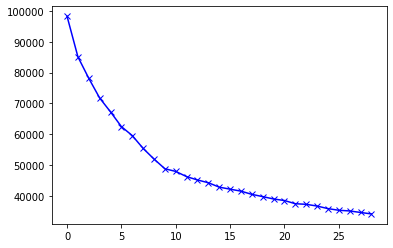

In [ ]:
n_clusters = 30               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1,n_clusters): # Пробегаем по списку от 1 до n_clusters
  kmean = KMeans(i)           # Создаем объект KMeans с i-классами
  kmean.fit(xTrain01Scaled)   # Проводим классетризацию xTrain01Scaled
  cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot(cost, 'bx-')
plt.show()

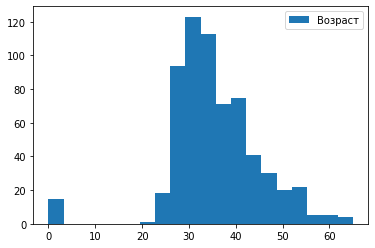

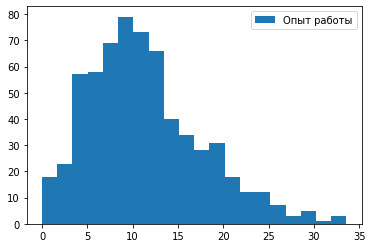

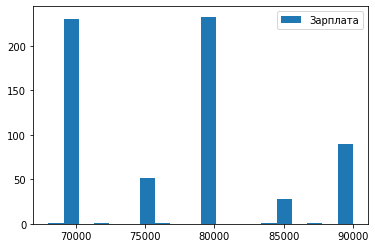

In [ ]:
clusterNumber = 3                          # Зададим номер кластера
cluster = xTrain01[labels==clusterNumber,:] # Получим из xTrain01 данные для указанного кластера
ages = cluster[:,1]                         # Получим все возраста в указанном кластере
exp = cluster[:,18] / 12                    # Получим все данные об опыте работы в указанном кластере
salary = cluster[:,19]                      # Получим все данные о желаемой зарплате в указанном кластере

# Отобразим полученные данные на графиках
plt.hist(ages,20, label="Возраст")
plt.legend()
plt.show()
plt.hist(exp,20, label="Опыт работы")
plt.legend()
plt.show()
plt.hist(salary,20, label="Зарплата")
plt.legend()
plt.show()

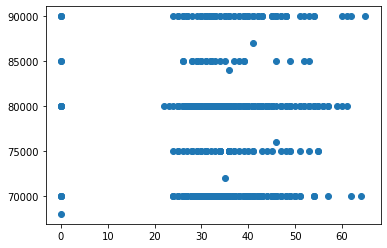

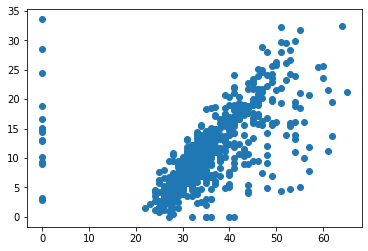

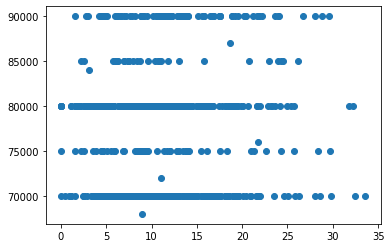

In [ ]:
plt.scatter(ages, salary)
plt.show()

plt.scatter(ages, exp)
plt.show()

plt.scatter(exp, salary)
plt.show()

**По специальности**

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=3667


In [ ]:
a = [[0,1,0],[0,1,0],[0,0,1],[1,0,0]]
np.mean(a, axis=0)

array([0.25, 0.5 , 0.25])

In [ ]:
clustersCount = 100           # Задаем количество кластеров
kmean = KMeans(clustersCount) # Создаем объект KMeans на clustersCount-классов
kmean.fit(xTrainProf01)       # Производим кластеризацию xTrainProf01
labelsProf = kmean.labels_    # Получаем список меток

In [ ]:
# Функция определяет ключевые слова в кластере
def printProfCluster(x, bias, vocabulary):
  mask = np.mean(x, axis=0) > bias # Создаем маску для набора x, среднии значения которого больше bias
  mX = np.mean(x, axis=0)*100      # Получаем среднее значение для набора данных x
  words = ""                       # Создаем пустую строку
  
  for w in vocabulary:            # Проходим по всем элементам словаря
    index = vocabulary[w]         # Считываем значение очередного элемента
    if (index < mask.shape[0]):   # Если значение меньше размерности списка-маски
      if (mask[index]):           # Если в массиве-маске есть само значение
        val = round(mX[index])    # Получаем значение в процентах
        words += w + " " + str(val) + "%" + "\n" # Формируем строку вывода
  
  print(words)                    # Выводим все найденные слова

In [ ]:
clusterNumber = 5                                                              # Указываем номер кластера
print("Размер кластера", sum(labelsProf==clusterNumber))                          # Выводим размер кластера
printProfCluster(xTrainProf01[labelsProf==clusterNumber,:], 0.5, vocabularyItems) # Получаем информацию по ключевым словам класетра

profs = xTrainTProf[labelsProf==clusterNumber]                                    # Получаем записи об указанном кластера
for p in profs:                                                                   # Выводим всю текстовую информацию в данном кластере
  print(p)

Размер кластера 156
специалист 97.0%
по 100.0%

Специалист по поддержке пользователей Медицинская сестра палатная
Аналитик-консультант 1С Специалист по планированию производства
Инженер Специалист по приёмке объектов связи
Ведущий специалист по интернет-маркетингу Директор по интернет - маркетингу
Специалист по интернет-маркетингу Автор идеи, создатель
специалист Старший специалист по операционной поддержке партнеров
Специалист по IT Специалист по IT
Специалист интернет-магазина по комплектации и доставке консультант по отделочным материалам
специалист по обработке заявок на сайте компании eruditor Group ст. преподаватель
Специалист по информированию о дебиторской задолженности Специалист центра сбора дебиторской задолженности
специалист по POS терминалам (Эквайринг) ведущий специалист по POS терминалам (эквайринг)
Специалист по информационным системам Специалист по информационным системам
Специалист по IT техник по ремонту ПК
Специалист по внедрению и сопровождению ПО Инженер-программ

In [ ]:
for clusterNumber in range(100):                                                    # Пробегаем в цикле от 0 до 100 
  print("Размер кластера", sum(labelsProf==clusterNumber))                          # Печатаем размер очередного кластера
  printProfCluster(xTrainProf01[labelsProf==clusterNumber,:], 0.5, vocabularyItems) # Получаем информацию по ключевым словам очередного кластера
  print()
  print()

Размер кластера 1
по 100.0%
и 100.0%
региональный 100.0%
представитель 100.0%
сфо 100.0%
урфо 100.0%
дфо 100.0%
республике 100.0%
казахстан 100.0%



Размер кластера 210
инженер 71.0%
программист 100.0%



Размер кластера 5
специалист 100.0%
и 100.0%
аналитик 60.0%
группы 60.0%



Размер кластера 114
менеджер 93.0%



Размер кластера 48
директор 100.0%



Размер кластера 156
специалист 97.0%
по 100.0%



Размер кластера 29
руководитель 86.0%
отдела 76.0%
проекта 100.0%
начальник 79.0%



Размер кластера 335
администратор 100.0%
системный 89.0%



Размер кластера 138
специалист 100.0%



Размер кластера 8
инженер 62.0%
по 88.0%
тестировщик 62.0%
qa 100.0%



Размер кластера 215



Размер кластера 11
специалист 91.0%
по 100.0%
ведущий 55.0%
поддержки 73.0%
технической 64.0%
с 100.0%
работе 100.0%
клиентами 91.0%



Размер кластера 11
по 100.0%
менеджер 64.0%
руководитель 100.0%
отдела 91.0%
с 91.0%
работе 100.0%
клиентами 82.0%



Размер кластера 3
по 100.0%
менеджер 100.0%
отдела 100.0%

Разбиение на 10 кластеров готово
Разбиение на 20 кластеров готово
Разбиение на 30 кластеров готово
Разбиение на 40 кластеров готово
Разбиение на 50 кластеров готово
Разбиение на 60 кластеров готово
Разбиение на 70 кластеров готово
Разбиение на 80 кластеров готово
Разбиение на 90 кластеров готово
Разбиение на 100 кластеров готово
Разбиение на 110 кластеров готово
Разбиение на 120 кластеров готово
Разбиение на 130 кластеров готово
Разбиение на 140 кластеров готово
Разбиение на 150 кластеров готово
Разбиение на 160 кластеров готово
Разбиение на 170 кластеров готово
Разбиение на 180 кластеров готово
Разбиение на 190 кластеров готово
Время обработки:  5491.88 c


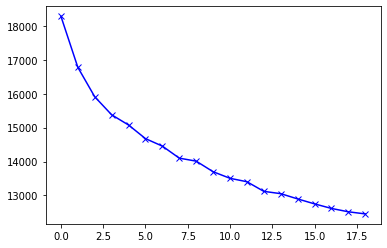

In [ ]:
import time
cur_time = time.time()
# Отобразим график разбияния на различное количество классов
cost = []
for i in range(1,20):
  print("Разбиение на ", i*10, " кластеров готово", sep="")
  kmean = KMeans(i*10)
  kmean.fit(xTrainProf01)
  cost.append(kmean.inertia_)
    
plt.plot(cost, 'bx-')
print('Время обработки: ', round(time.time()-cur_time,2),'c');

## Предсказание нового элемента

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=4472




In [ ]:
xTrainProf01[15]

array([0., 0., 1., ..., 0., 0., 0.])

In [ ]:
print(kmean.predict([xTrainProf01[15]])) # Определяем к какому кластеру относиться элемент

[92]


In [ ]:
xTrainTProf[labelsProf==92]

array(['Оператор ПК Инженер-проектировщик ОВИК',
       'Оператор ПК Техник оператор ЭВМ',
       'Продавец электроники/ Сборщик пк Координатор',
       'Сборщик ПК Сборщик ПК', 'Оператор ПК Заместитель директора',
       'Оператор ПК Фрилансер',
       'Ночной оператор ПК в Академгородок Специалист отдела проектирования',
       'Оператор ПК УМЦ "Знание"', 'Сборщик ПК Бригадир',
       'Оператор ПК Оператор ЭВМ', 'Оператор ПК (ЭВМ) Оператор ЭВМ',
       'Оператор ПК на дому начальник отдела механизации, автотранспорта и энергетики',
       'водитель,личный водитель. оператор пк', 'Оператор Оператор ПК',
       'Оператор Оператор ПК', 'Сборщик ПК Стажер полицейский-кавалерист',
       'ПК Помощник машиниста электровоза', 'Сборщик ПК Мастер-приемщик',
       'Сборщик ПК сборщик', 'Оператор пк, Оператор ЭВМ',
       'Инженер Сборшик ПК ноутбуков руководитель отдела сборки оператор тестирования ноутбуков',
       'Оператор Продавец- кассир, Оператор ПК + справочная служба, Оператор-кассир

In [ ]:
xTrainTProf[15]                          # Отобразим рассматриваемый элемент

'Оператор ПК Инженер-проектировщик ОВИК'

## Иерархическая кластеризация

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=4724


In [ ]:
from sklearn.cluster import AgglomerativeClustering                                     # Импортируем модуль иерархической кластирезации

cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  # Создаем объект AgglomerativeClustering
cluster.fit_predict(xTrain01Scaled)                                                     # Производим класстеризацию набора xTrain01Scaled

array([7, 1, 6, ..., 0, 6, 3])

In [ ]:
labels = cluster.labels_ # Получаем список меток
print(labels[:20])       # Выводим первые 20 меток

[7 1 6 0 3 2 1 1 1 7 1 4 6 2 5 0 4 9 3 6]


In [ ]:
clusterNumber = 0                               # Указываем номер кластера
printCluster(xTrain01[labels==clusterNumber,:]) # Выводим информацию указанного кластера

Размер кластера: 498
Пол: 51.0% мужчины
Возраст: 34.0, разброс: 11.5
Опыт работы: 9.7, разброс: 6.7
Зарплата: 50181.0, разброс: 57397.0

Территориально
Москва: 21.0%
Санкт-Петербург: 9.0%
Города миллионники: 15.0%
Другие города: 55.0%

Тип занятости
Стажировка: 0.0%
Частичная занятость: 62.0%
Проектная работа: 24.0%
Полная занятость: 40.0%

График
Гибкий график: 42.0%
Полный день: 3.0%
Сменный график: 24.0%
Удаленная работа: 61.0%

Образование
Высшее: 75.0%
Среднее специальное: 14.0%
Неоконченное высшее: 10.0%
Среднее образование: 0.0%


# Кластеризация корзин интернет-магазина

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=4974


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/online_carts.csv') # Читаем данные из загруженной базы

In [ ]:
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Посмотрим на уникальные значения каждого из безымянных столбцов
print(df['Unnamed: 0'].unique(),
      df['Unnamed: 2'].unique(),
      df['Unnamed: 3'].unique(),sep='\n')

[nan]
[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']
[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648'

In [ ]:
new = df.drop(['Unnamed: 0'], axis =1)                             # Этот столбец не несет никакой информации, так что выкинем его
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
new = new.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [ ]:
new.head(30)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,3,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,4,unknown,unknown,unknown,unknown
5,5,ЗаказПокупателя.Дата оправки,Стоимость продажи (руб.),Количество,unknown
6,6,ЗаказПокупателя.ID заказа,С НДС,Базовых ед.,unknown
7,7,Номенклатура.Наименование,unknown,unknown,unknown
8,8,unknown,unknown,unknown,unknown
9,9,01.01.2019 0:00:00,26236,9,unknown


In [ ]:
new[new['Валовая прибыль'].str.contains("MCOSM")] # MCOSM - флаг начала корзины

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown
...,...,...,...,...,...
99589,99589,MCOSM33527,2714,6,unknown
99596,99596,MCOSM33529,3145,9,unknown
99603,99603,MCOSM33530,3030,12,unknown
99616,99616,MCOSM33537,2259,2,unknown


In [ ]:
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index) # Здесь будут лежать все индексы строк, где есть информация в формате даты

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown
...,...,...,...,...,...
99627,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99628,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99629,02.09.2019 0:00:00,Услуга доставки DPD до двери,350,1,unknown
99630,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Выкинем превьюшные строки
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Выкинем пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Выкинем строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM")].index)        # Здесь будут лежать все индексы строк, где строка содержит флаг начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE")].index)       # Здесь будут лежать все индексы строк, где строка содержит флаг CAFRE 

Взглянем на распаршенную базу

In [ ]:
new.head()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown


In [ ]:
carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка

  if i in cart_list:           # Если счетчик в списке индексов-корзин

    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1 
      
    else:                      # Если же текущий индекс-флаг последний в списке

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен концу списка всех строк в столбце-1
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1

    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
    
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем
 


In [ ]:
print(len(carts)==len(cart_list))   # Проверка, если у нас количество корзин совпадает с количеством флагов корзин
print('Количество всех позиций: ', len(allPositions)) 
print('Пример того, что лежит в корзине: ', carts[0])

True
Количество всех позиций:  85617
Пример того, что лежит в корзине:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']


In [ ]:
for i in range(10):
    print(carts[i])

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл', 'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл', 'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.', 'Услуга доставки Почта России', '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный', '/44 Крем-краска ESTEL PRINCESS ESSEX медный', '0/00 Стойкая крем-краска чистый тон', '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный', '0/11 Крем-краска ESTEL PRINCESS ESSEX синий', '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый', '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый', '0/33 Стойкая крем-краска интенсивный золотистисты', '0/55 Крем-краска

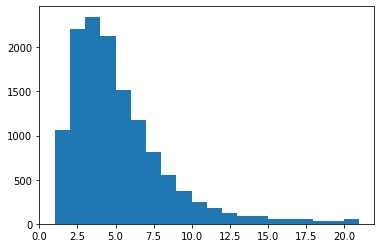

In [ ]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [ ]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
print(maxPositionsCount)                                        # Отобразим это количество

6663


In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts] # Создаем список индексов для каждой корзины

In [ ]:
n = 5                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5742 5743]


In [ ]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список  
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [ ]:
n = 5                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5742 5743]
[0. 0. 0. ... 0. 0. 0.]


## Кластеризация

*Разбор данного раздела:* https://youtu.be/3LeYSKkVCMk?t=5578

In [ ]:
cur_time = time.time()
clustersCount = 100                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)                            # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  465.26 c


In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)

[37 71 37 ... 14 14 47]
0 1
1 170
2 219
3 312
4 20
5 70
6 132
7 17
8 15
9 125
10 277
11 1
12 1
13 33
14 3326
15 1
16 2
17 1
18 1
19 1
20 1
21 1
22 245
23 1
24 1
25 41
26 1
27 1
28 1
29 256
30 1
31 59
32 1
33 1
34 59
35 1
36 1
37 3463
38 1
39 1
40 1
41 1
42 1
43 2
44 143
45 1
46 1
47 773
48 1
49 1
50 1
51 143
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 5
60 107
61 1
62 1
63 48
64 1
65 1
66 1
67 141
68 1
69 1
70 1
71 1
72 1
73 1
74 96
75 1
76 1
77 2
78 1
79 158
80 1
81 1
82 8
83 1
84 1
85 1
86 1
87 1
88 1
89 60
90 12
91 1
92 1
93 1
94 4
95 2870
96 75
97 1
98 1
99 16


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим насколько часто конкретная позиция появляется в данном кластере
  
  positions = []                                     # Создаем пустой список позиций
  positionValues = []                                # Создаем пустой список значений
  
  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций 
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере
  
  return positions, positionValues                   # Возвращаем список позиций кластера и количество каждой позиции

In [ ]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 170
Позиций: 437
68.0% ['Услуга доставки Почта России']
100.0% ['Эмульсия для удаления краски с волос']


Покупок: 219
Позиций: 664
90.0% ['Хромоэнергетический комплекс']


Покупок: 312
Позиций: 904
74.0% ['Бальзам для ежедневного применения 1000 мл. Curex Classic']
94.0% ['Шампунь для ежедневного применения 1000 мл. Curex Classic']


Покупок: 20
Позиций: 254
70.0% ['Крем для естественного загара в солярии Delicato 12 мл.']
75.0% ['Крем для загара в солярии Blue Lagoon 12 мл.']
80.0% ['Крем для загара в солярии Brown Coco Nectar 15 мл.']
80.0% ['Крем для загара в солярии Brown Mango Nectar 15 мл.']
70.0% ['Крем для загара в солярии Daiquiri 12 мл.']
90.0% ['Крем для загара в солярии Dark Mango Nectar 15 мл.']


Покупок: 70
Позиций: 290
66.0% ['Набор для процедуры ламинирования волос']


Покупок: 132
Позиций: 552
100.0% ['Шампунь для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']


Покупок: 17
Позиций: 303
65.0% ['10/38 Стойкая крем-краскад/в яркий блонд золотисто']
65.0% 

Готово разбиение на 20 классов
Готово разбиение на 40 классов
Готово разбиение на 60 классов
Готово разбиение на 80 классов
Готово разбиение на 100 классов
Готово разбиение на 120 классов
Готово разбиение на 140 классов
Готово разбиение на 160 классов
Готово разбиение на 180 классов
Готово разбиение на 200 классов
Готово разбиение на 220 классов
Готово разбиение на 240 классов
Готово разбиение на 260 классов
Готово разбиение на 280 классов


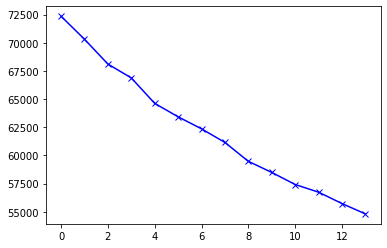

In [ ]:
cost = []
for i in range(1,15):
  kmean = KMeans(i*20)
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i*20, " классов", sep="")
    
plt.plot(cost, 'bx-')

In [ ]:
# Разбиение на 280 классов
for clusterNumber in range(max(labels)):                     # Пробегаем по всем значениям
    if (clusterSize[clusterNumber] > 5):                     # Если размер кластера больше 5
      pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
      print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
      print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
      pos = np.array(pos)                                      # Преобразуем в numpy
      posVal = np.array(posVal)                                # Преобразуем в numpy
      indexes = posVal > 0.2                                   # Берем индексы тех позиций, доля которых составляет больше 20%
      indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
      indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

      # Отображаем долю позиции и название самой позиции
      for i in range(len(indexedPos)):
        print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

      print()
      print()

Покупок: 170
Позиций: 437
68.0% ['Услуга доставки Почта России']
100.0% ['Эмульсия для удаления краски с волос']


Покупок: 219
Позиций: 664
21.0% ['Активатор 900 мл DE LUXE']
22.0% ['Оксигент 3% 900 мл DE LUXE']
27.0% ['Оксигент 6% 900 мл DE LUXE']
90.0% ['Хромоэнергетический комплекс']


Покупок: 312
Позиций: 904
74.0% ['Бальзам для ежедневного применения 1000 мл. Curex Classic']
94.0% ['Шампунь для ежедневного применения 1000 мл. Curex Classic']


Покупок: 20
Позиций: 254
70.0% ['Крем для естественного загара в солярии Delicato 12 мл.']
75.0% ['Крем для загара в солярии Blue Lagoon 12 мл.']
80.0% ['Крем для загара в солярии Brown Coco Nectar 15 мл.']
80.0% ['Крем для загара в солярии Brown Mango Nectar 15 мл.']
60.0% ['Крем для загара в солярии Choсоlate 15 мл.']
50.0% ['Крем для загара в солярии Cool Bronzing Formula 15 мл.']
35.0% ['Крем для загара в солярии Courage 15 мл.']
40.0% ['Крем для загара в солярии Cоcоa Bronzing Yogurt 15 мл.']
70.0% ['Крем для загара в солярии Daiquiri